In [38]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_df= pd.read_csv("Train.csv", usecols=["ClassId", "Path"])
test_df= pd.read_csv("Test.csv", usecols= ["ClassId", "Path"])

In [3]:
train_df.head()

,ClassId,Path
0,20,Train/20/00020_00000_00000.png
1,20,Train/20/00020_00000_00001.png
2,20,Train/20/00020_00000_00002.png
3,20,Train/20/00020_00000_00003.png
4,20,Train/20/00020_00000_00004.png


In [4]:
test_df.head()

,ClassId,Path
0,16,Test/00000.png
1,1,Test/00001.png
2,38,Test/00002.png
3,33,Test/00003.png
4,11,Test/00004.png


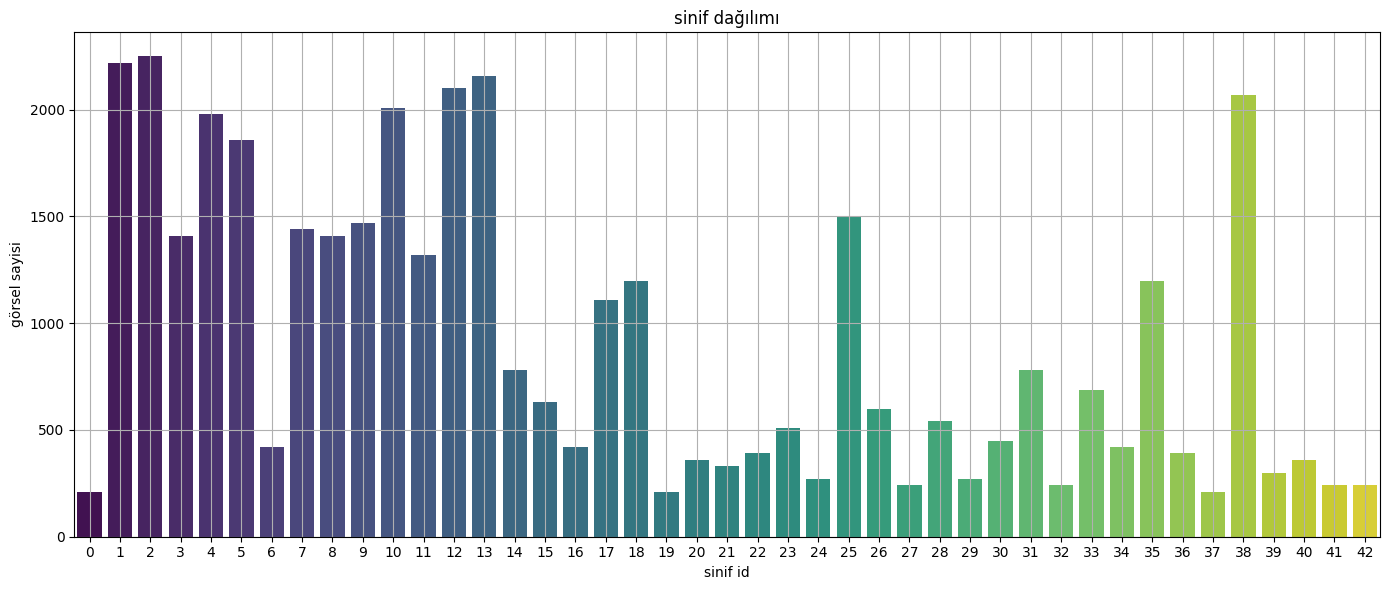

In [5]:
plt.figure(figsize=(14,6))
sns.countplot(x="ClassId", data=train_df, palette="viridis")
plt.title("sinif dağılımı")
plt.xlabel("sinif id")
plt.ylabel("görsel sayisi")
plt.grid()
plt.tight_layout()
plt.show()

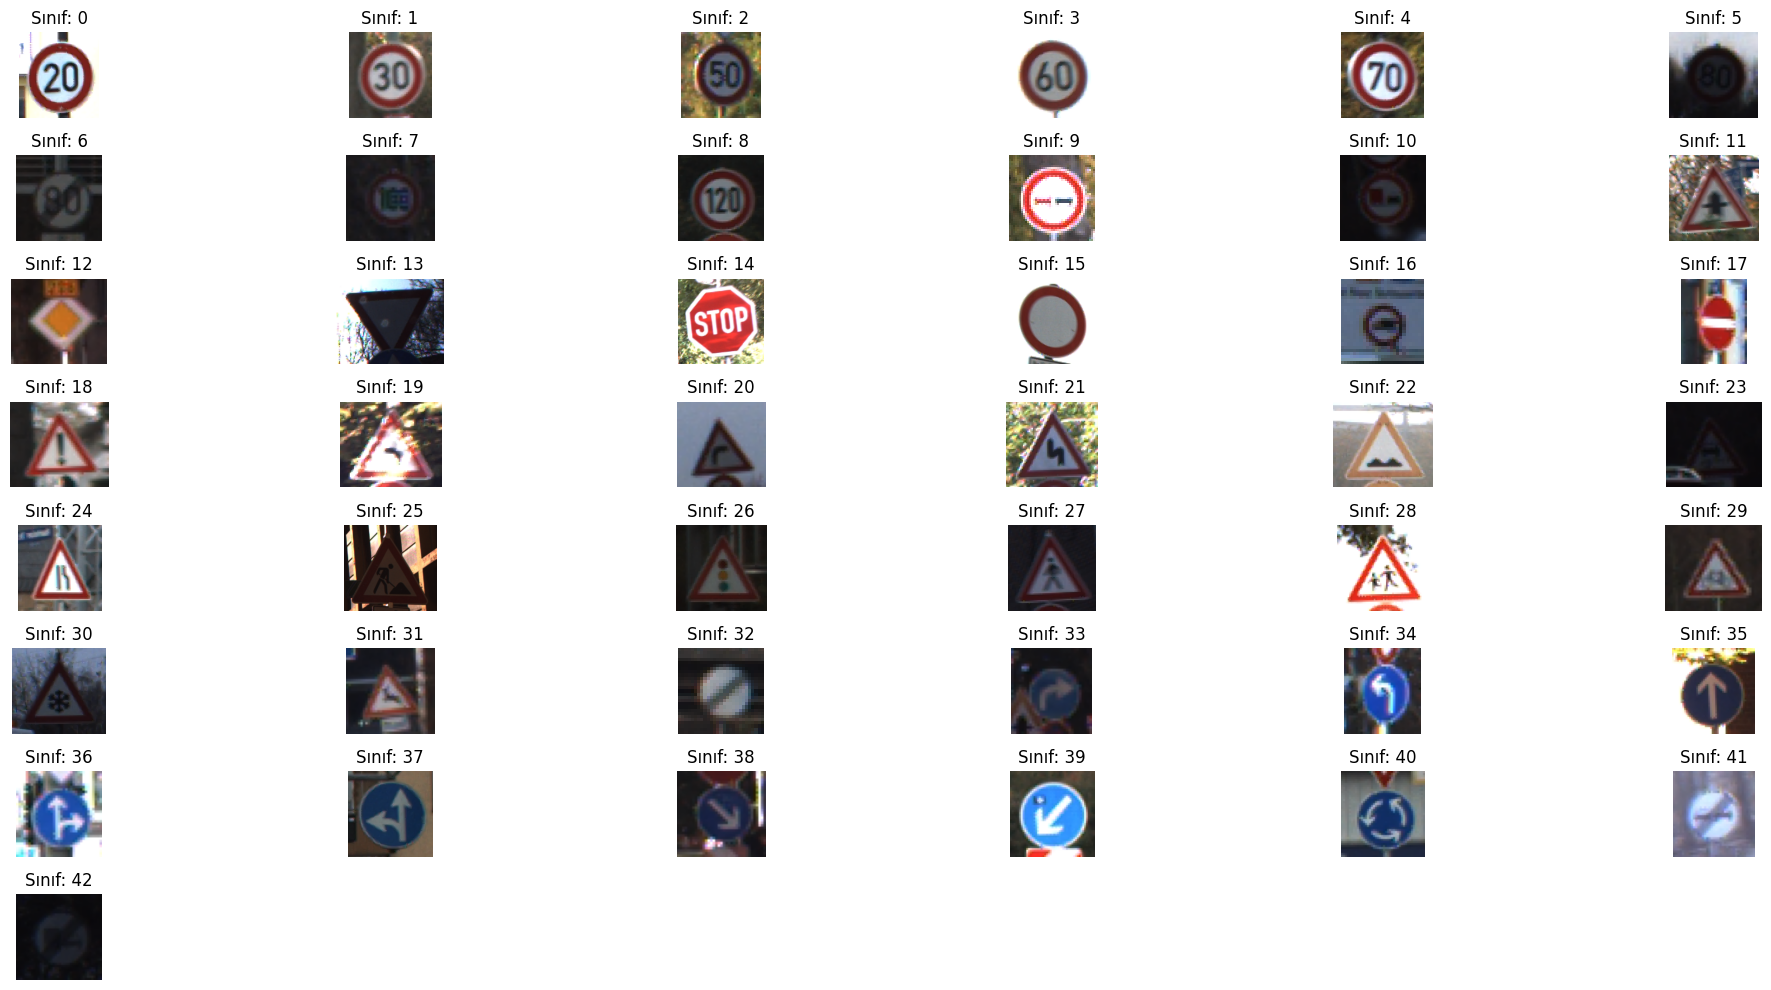

In [6]:
plt.figure(figsize=(20,10))
classes= sorted(train_df["ClassId"].unique())

for i, c in enumerate(classes):
    sample= train_df[train_df["ClassId"]==c].sample(1).iloc[0]
    img= Image.open(sample["Path"])
    plt.subplot(8, 6, i+1)
    plt.imshow(img)
    plt.title(f"Sınıf: {c}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["ClassId"])

In [8]:
print(f"Number of Sample for Train  : {len(train_df)}")
print(f"Number of Sample for Validation: {len(val_df)}")

Number of Sample for Train  : 31367
Number of Sample for Validation: 7842


In [9]:
train_aug = A.Compose([A.Resize(224,224),
                       A.RandomShadow(p=0.2),
                       A.RandomFog(p=0.1),
                       A.RandomBrightnessContrast(p=0.3),
                       A.RandomGamma(gamma_limit=(90, 110), p=0.3),
                       A.GaussianBlur(blur_limit=(3, 7), p=0.2),
                       A.MotionBlur(p=0.2),
                       A.Rotate(limit=15, p=0.4)])

In [10]:
val_aug= A.Compose([A.Resize(224,224)])

In [11]:
class DataGenerator(Sequence):

    def __init__ (self, df, base_dir=".", batch_size=32, target_size=(224,224), num_classes=43, augmentations=None, shuffle=True):
        self.df = df.reset_index(drop=True).copy() 
        self.base_dir=base_dir
        self.batch_size=batch_size
        self.target_size=target_size
        self.num_classes=num_classes
        self.augmentations=augmentations
        self.shuffle=shuffle
        self.indices=self.df.index.tolist()
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices)/self.batch_size))

    def __getitem__(self,index):
        indices_for_batch = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df= self.df.iloc[indices_for_batch]
        X,y= self.__data_generation(batch_df)
        return X,y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_df):
        X=np.empty((len(batch_df), *self.target_size, 3), dtype=np.float32)
        y=np.empty((len(batch_df)), dtype=int)

        for i, (idx, row) in enumerate(batch_df.iterrows()):
            img_path= os.path.join(self.base_dir, row["Path"])
            img=cv2.imread(img_path)
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if self.augmentations:
                augmented=self.augmentations(image=img)
                img=augmented["image"]

            img=preprocess_input(img.astype(np.float32))
            X[i,]=img
            y[i]=row["ClassId"]
        return X, to_categorical(y, num_classes=self.num_classes)
    

In [12]:
train_gen= DataGenerator(df= train_df,
                         base_dir= ".",
                         batch_size=32,
                         target_size=(224,224),
                         num_classes=43,
                         augmentations=train_aug,
                         shuffle=True)

In [13]:
val_gen= DataGenerator(df=val_df,
                       base_dir=".",
                       batch_size=32,
                       target_size=(224,224),
                       num_classes=43,
                       augmentations=val_aug,
                       shuffle=False)

In [14]:
def build_model(num_classes):
    base_model= EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(224,224,3))
    base_model.trainable=False
    inputs=Input(shape=(224,224,3))
    x=base_model(inputs, training=False)
    x=GlobalAveragePooling2D()(x)
    x=Dropout(0.3)(x)
    outputs=Dense(num_classes, activation="softmax")(x)
    model=Model(inputs,outputs)
    return model

In [15]:
model = build_model(num_classes=43)

In [16]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
callbacks=[ModelCheckpoint("gtsrb_model.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1),
           EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
           ReduceLROnPlateau(monitor="val_loss", factor=0.4, patience=3, min_lr=1e-6)]

In [18]:
history=model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks)

Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.4463 - loss: 2.0306   
Epoch 1: val_accuracy improved from -inf to 0.80464, saving model to gtsrb_model.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 902s 908ms/step - accuracy: 0.4465 - loss: 2.0301 - val_accuracy: 0.8046 - val_loss: 0.7211 - learning_rate: 0.0010
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.7050 - loss: 1.0173    
Epoch 2: val_accuracy improved from 0.80464 to 0.86674, saving model to gtsrb_model.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 1031s 1s/step - accuracy: 0.7050 - loss: 1.0172 - val_accuracy: 0.8667 - val_loss: 0.5004 - learning_rate: 0.0010
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.7497 - loss: 0.8408   
Epoch 3: val_accuracy improved from 0.86674 to 0.89939, saving model to gtsrb_model.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 899s 917ms/step - accuracy: 0.7497 - loss: 0.8408 - val_accuracy: 0.8994 - val_loss: 0.4021 - learning_rate: 0.0010
Epoch 4/30
981/981 ━━━━━━━

In [20]:
from tensorflow.keras.models import load_model

In [21]:
model = load_model("gtsrb_model.keras")

In [23]:
base_model = model.layers[1]
base_model.trainable=True
for layer in base_model.layers[:-30]:
    layer.trainable=False

In [24]:
model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [25]:
callbacks = [EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
             ModelCheckpoint("gtsrb_finetuned.keras", save_best_only=True, monitor="val_loss")]

In [26]:
history_finetune=model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 951s 955ms/step - accuracy: 0.7366 - loss: 0.8933 - val_accuracy: 0.9453 - val_loss: 0.1901
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 652s 665ms/step - accuracy: 0.7898 - loss: 0.6833 - val_accuracy: 0.9523 - val_loss: 0.1603
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 651s 664ms/step - accuracy: 0.8079 - loss: 0.6125 - val_accuracy: 0.9564 - val_loss: 0.1442
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 651s 663ms/step - accuracy: 0.8168 - loss: 0.5808 - val_accuracy: 0.9593 - val_loss: 0.1320
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 653s 666ms/step - accuracy: 0.8300 - loss: 0.5395 - val_accuracy: 0.9638 - val_loss: 0.1208
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 684s 697ms/step - accuracy: 0.8344 - loss: 0.5270 - val_accuracy: 0.9663 - val_loss: 0.1130
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 729s 743ms/step - accuracy: 0.8455 - loss: 0.4911 - val_accuracy: 0.9684 - val_loss: 0.1065
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 772s 787ms/step - accuracy: 0.8502 -

In [29]:
test_aug= A.Compose([A.Resize(224,224)])

In [30]:
test_gen= DataGenerator(df=test_df,
                       base_dir=".",
                       batch_size=32,
                       target_size=(224,224),
                       num_classes=43,
                       augmentations=test_aug,
                       shuffle=False)

In [31]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 368s 929ms/step - accuracy: 0.8727 - loss: 0.3965 
Test Accuracy: 0.8694


In [36]:
y_true = test_df["ClassId"].tolist()
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 182s 452ms/step


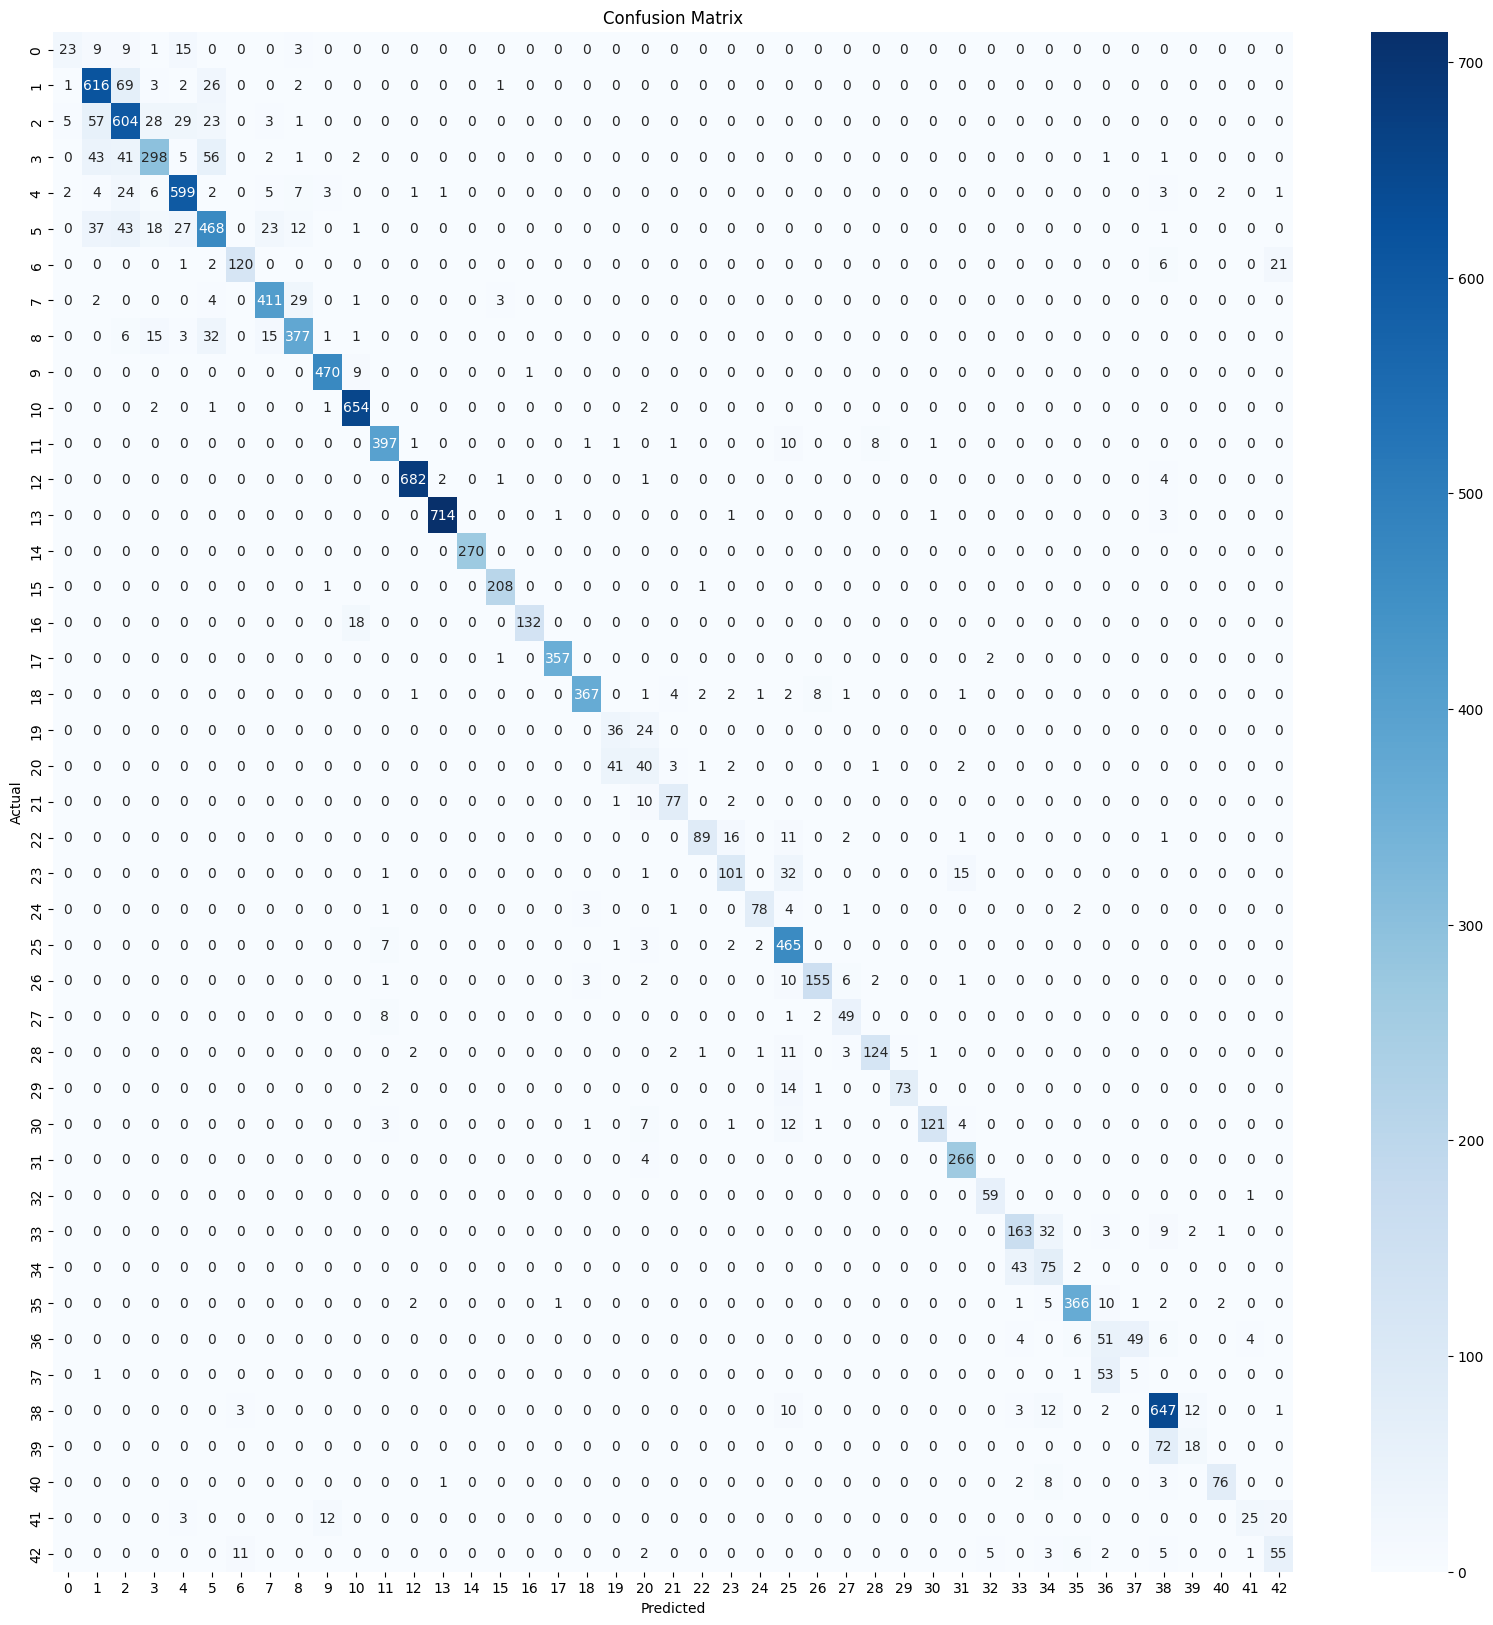

In [39]:
plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [40]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.38      0.51        60
           1       0.80      0.86      0.83       720
           2       0.76      0.81      0.78       750
           3       0.80      0.66      0.73       450
           4       0.88      0.91      0.89       660
           5       0.76      0.74      0.75       630
           6       0.90      0.80      0.85       150
           7       0.90      0.91      0.90       450
           8       0.87      0.84      0.85       450
           9       0.96      0.98      0.97       480
          10       0.95      0.99      0.97       660
          11       0.95      0.95      0.95       420
          12       0.99      0.99      0.99       690
          13       0.99      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.97      0.99      0.98       210
          16       0.99      0.88      0.93       150
          17       0.99    

In [59]:
BASE_DIR = "C:/Users/PANDA/traffic_sign/" 

def predict_and_visualize(img_path, model, train_df, base_dir):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_processed = img_rgb.astype("float32")
    img_processed = preprocess_input(img_processed)
    img_processed = np.expand_dims(img_processed, axis=0)

    prediction = model.predict(img_processed)[0]
    predicted_class_id = int(np.argmax(prediction))  # int olarak kalsın
    confidence = prediction[predicted_class_id]

    print(f"Tahmin edilen sınıf: {predicted_class_id} | Güven skoru: {confidence:.2f}")

    samples = train_df[train_df["ClassId"] == predicted_class_id]
    if len(samples) == 0:
        print(f" Train verisinde sınıf {predicted_class_id} bulunamadı.")
        return

    sample_from_train_df = samples.sample(1).iloc[0]
    train_sample_relative_path = sample_from_train_df["Path"]
    train_sample_full_path = os.path.join(base_dir, train_sample_relative_path)

    train_sample_img_bgr = cv2.imread(train_sample_full_path)
    train_sample_img_rgb = cv2.cvtColor(train_sample_img_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f"Tahmin Edilen\nSınıf {predicted_class_id}", color="green")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(train_sample_img_rgb)
    plt.title(f"Train Örneği\nSınıf {predicted_class_id}", color="blue")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Tahmin edilen sınıf: 2 | Güven skoru: 0.99


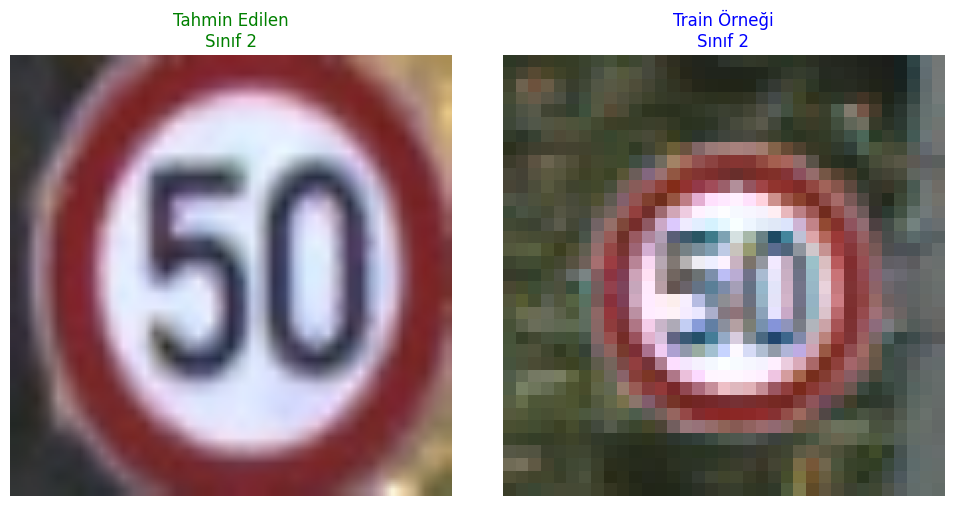

In [62]:
predict_and_visualize("50.png", model, train_df, BASE_DIR)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Tahmin edilen sınıf: 4 | Güven skoru: 1.00


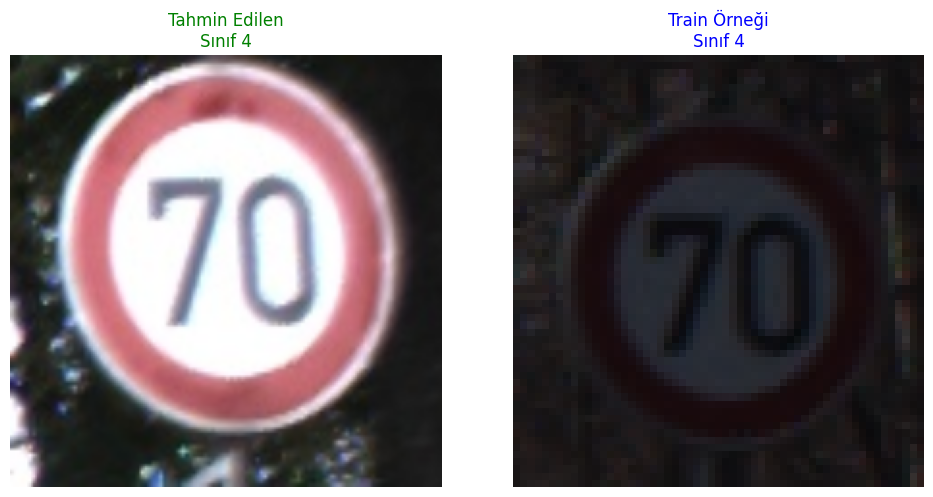

In [63]:
predict_and_visualize("70.png", model, train_df, BASE_DIR)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Tahmin edilen sınıf: 34 | Güven skoru: 0.98


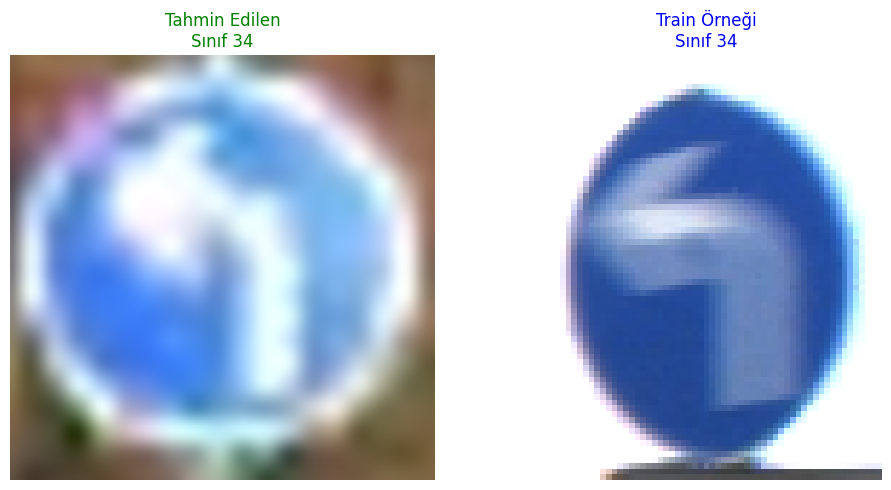

In [67]:
predict_and_visualize("sol.png", model, train_df, BASE_DIR)